# Late Fusion Model for Outcome Classification

This notebook implements late fusion combining:
- **Physiological data** (pupil metrics)
- **Behavioral data** (reaction time, decision time, etc.)
- **Gaze data** (gaze position, movements, fixations)

Goals:
1. Train separate models for each modality
2. Implement late fusion (stacking/weight averaging)
3. Extract weights to estimate modality influence on predictions

In [7]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Pre-Extracted Features

In [8]:
import pickle

# Load pre-extracted features
with open('../../data/results/features_POST/extracted_features_POST.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology (POST): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")
print(f"\nOutcome distribution:")
print(merged_df['outcome'].value_counts())


✓ Loaded 12511 trials from 97 subjects
  Features extracted on: 2025-12-12 16:04:34
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (POST): 13 features
  Behavior: 7 features
  Gaze: 20 features

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


## 2. Prepare Feature Sets

In [9]:
# Prepare feature arrays for model training
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Shapes: X_physio=(12511, 13), X_behavior=(12511, 7), X_gaze=(12511, 20)


## 3. Train Individual Modality Models

In [10]:
def train_evaluate_modality(X, y, subjects, modality_name):
    """Train and evaluate model with LOSO cross-validation."""
    print(f"\n{'='*50}\n{modality_name} Model\n{'='*50}")
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10,
                                   min_samples_leaf=5, random_state=42,
                                   class_weight='balanced')
    logo = LeaveOneGroupOut()
    
    accs, f1s, preds_all, y_true_all = [], [], [], []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accs.append(acc)
        f1s.append(f1)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-Score: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    
    return model, np.mean(accs), np.mean(f1s), preds_all, y_true_all

model_physio, acc_physio, f1_physio, pred_physio, y_true = train_evaluate_modality(
    X_physio, y, subjects, "Physiology"
)
model_behavior, acc_behavior, f1_behavior, pred_behavior, _ = train_evaluate_modality(
    X_behavior, y, subjects, "Behavior"
)
model_gaze, acc_gaze, f1_gaze, pred_gaze, _ = train_evaluate_modality(
    X_gaze, y, subjects, "Gaze"
)


Physiology Model
Accuracy: 0.535 ± 0.117
F1-Score: 0.549 ± 0.122

Behavior Model
Accuracy: 0.647 ± 0.137
F1-Score: 0.661 ± 0.146

Gaze Model
Accuracy: 0.491 ± 0.143
F1-Score: 0.470 ± 0.170


## 4. Late Fusion Implementation

In [11]:
def late_fusion(X_modalities, y, subjects, modality_names, fusion_method='weighted'):
    """
    Late fusion by combining modality predictions.
    
    fusion_method:
    - 'average': Simple average of probabilities
    - 'weighted': Learn weights via logistic regression (meta-learner)
    - 'stacking': Random Forest meta-learner on probability predictions
    """
    print(f"\n{'='*50}\nLate Fusion: {fusion_method.upper()}\n{'='*50}")
    
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10,
                                          min_samples_leaf=5, random_state=42,
                                          class_weight='balanced')
                   for _ in X_modalities]
    
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    preds_all, y_true_all = [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        # Train base models and get probabilities
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fusion
        if fusion_method == 'average':
            y_pred = (np.mean(test_probs, axis=1) > 0.5).astype(int)
            weights = np.ones(len(X_modalities)) / len(X_modalities)
            
        elif fusion_method == 'weighted':
            meta = LogisticRegression(random_state=42, max_iter=1000)
            meta.fit(train_probs, y_train)
            weights = meta.coef_[0]
            y_pred = meta.predict(test_probs)
            
        elif fusion_method == 'stacking':
            meta = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, class_weight='balanced')
            meta.fit(train_probs, y_train)
            weights = meta.feature_importances_
            y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    # Convert to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    
    # Normalize weights
    if fusion_method == 'weighted':
        norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    else:
        norm_weights = avg_weights / np.sum(avg_weights)
    
    print(f"Accuracy: {np.mean(subject_acc_values):.3f} ± {stats.sem(subject_acc_values):.3f} (SEM)")
    print(f"F1-Score: {np.mean(subject_f1_values):.3f} ± {stats.sem(subject_f1_values):.3f} (SEM)")
    print(f"\nModality Weights:")
    for name, w in zip(modality_names, norm_weights):
        print(f"  {name}: {w:.3f}")
    
    return {
        'accuracy': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'f1_score': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'weights': norm_weights,
        'modality_names': modality_names,
        'predictions': preds_all,
        'y_true': y_true_all
    }

In [12]:
# Run all fusion methods
X_modalities = [X_physio, X_behavior, X_gaze]
modality_names = ['Physiology', 'Behavior', 'Gaze']

results_avg = late_fusion(X_modalities, y, subjects, modality_names, 'average')
results_weighted = late_fusion(X_modalities, y, subjects, modality_names, 'weighted')
results_stacking = late_fusion(X_modalities, y, subjects, modality_names, 'stacking')


Late Fusion: AVERAGE
Accuracy: 0.644 ± 0.014 (SEM)
F1-Score: 0.650 ± 0.016 (SEM)

Modality Weights:
  Physiology: 0.333
  Behavior: 0.333
  Gaze: 0.333

Late Fusion: WEIGHTED
Accuracy: 0.678 ± 0.015 (SEM)
F1-Score: 0.663 ± 0.017 (SEM)

Modality Weights:
  Physiology: 0.505
  Behavior: 0.050
  Gaze: 0.445

Late Fusion: STACKING
Accuracy: 0.627 ± 0.014 (SEM)
F1-Score: 0.630 ± 0.016 (SEM)

Modality Weights:
  Physiology: 0.214
  Behavior: 0.494
  Gaze: 0.293


## 5. Compare All Methods


PERFORMANCE COMPARISON
         Method  Accuracy  F1-Score
Physiology Only  0.535138  0.548705
  Behavior Only  0.647486  0.660967
      Gaze Only  0.490667  0.470342
 Average Fusion  0.643954  0.649534
Weighted Fusion  0.677953  0.663132
       Stacking  0.627307  0.629865


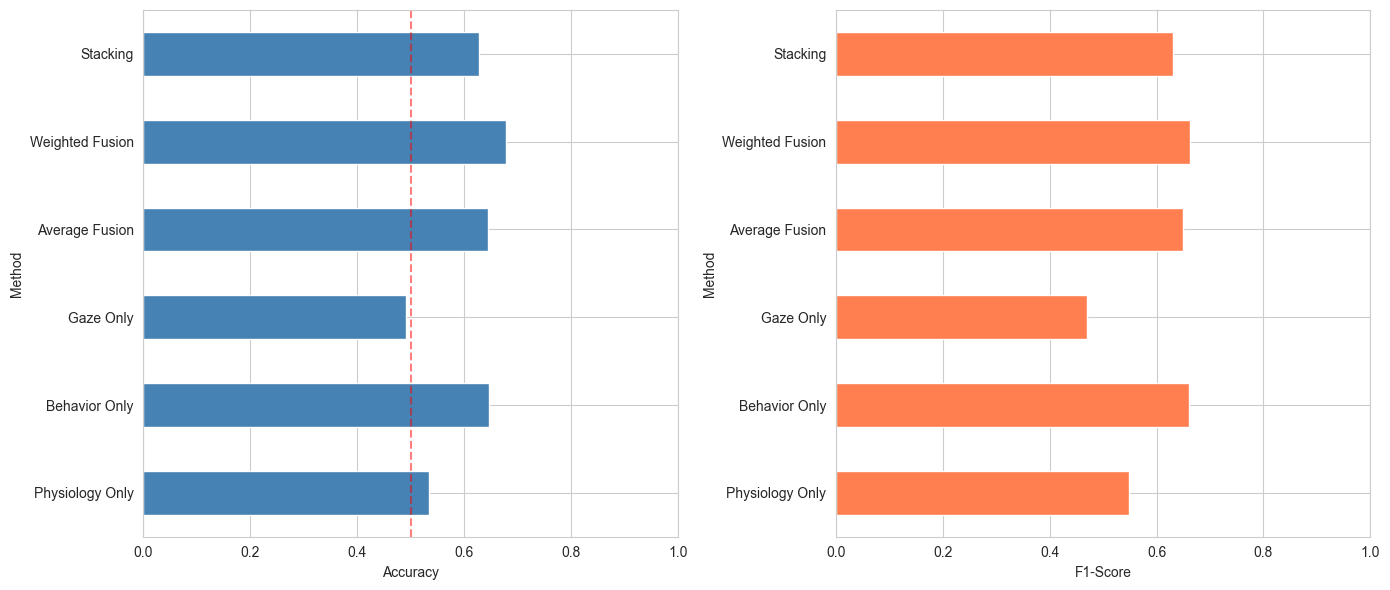

In [13]:
comparison_df = pd.DataFrame({
    'Method': ['Physiology Only', 'Behavior Only', 'Gaze Only',
               'Average Fusion', 'Weighted Fusion', 'Stacking'],
    'Accuracy': [acc_physio, acc_behavior, acc_gaze,
                 results_avg['accuracy'], results_weighted['accuracy'], results_stacking['accuracy']],
    'F1-Score': [f1_physio, f1_behavior, f1_gaze,
                 results_avg['f1_score'], results_weighted['f1_score'], results_stacking['f1_score']]
})

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
comparison_df.plot(x='Method', y='Accuracy', kind='barh', ax=ax[0], legend=False, color='steelblue')
ax[0].set_xlabel('Accuracy')
ax[0].set_xlim([0, 1])
ax[0].axvline(0.5, color='red', linestyle='--', alpha=0.5)
comparison_df.plot(x='Method', y='F1-Score', kind='barh', ax=ax[1], legend=False, color='coral')
ax[1].set_xlabel('F1-Score')
ax[1].set_xlim([0, 1])
plt.tight_layout()
plt.show()

## 6. Visualize Modality Weights

In [14]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print("\n1. INDIVIDUAL MODALITIES:")
print(f"   Physiology:  Acc={acc_physio:.3f}, F1={f1_physio:.3f}")
print(f"   Behavior:    Acc={acc_behavior:.3f}, F1={f1_behavior:.3f}")
print(f"   Gaze:        Acc={acc_gaze:.3f}, F1={f1_gaze:.3f}")

print("\n2. LATE FUSION METHODS:")
print(f"   Average:     Acc={results_avg['accuracy']:.3f}, F1={results_avg['f1_score']:.3f}")
print(f"   Weighted:    Acc={results_weighted['accuracy']:.3f}, F1={results_weighted['f1_score']:.3f}")
print(f"   Stacking:    Acc={results_stacking['accuracy']:.3f}, F1={results_stacking['f1_score']:.3f}")

print("\n3. MODALITY CONTRIBUTIONS (Weighted Fusion):")
for name, w in zip(modality_names, results_weighted['weights']):
    print(f"   {name:12s}: {w*100:5.1f}%")

best = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n4. BEST METHOD: {best['Method']} (Acc={best['Accuracy']:.3f})")
print("\n" + "="*70)


SUMMARY

1. INDIVIDUAL MODALITIES:
   Physiology:  Acc=0.535, F1=0.549
   Behavior:    Acc=0.647, F1=0.661
   Gaze:        Acc=0.491, F1=0.470

2. LATE FUSION METHODS:
   Average:     Acc=0.644, F1=0.650
   Weighted:    Acc=0.678, F1=0.663
   Stacking:    Acc=0.627, F1=0.630

3. MODALITY CONTRIBUTIONS (Weighted Fusion):
   Physiology  :  50.5%
   Behavior    :   5.0%
   Gaze        :  44.5%

4. BEST METHOD: Weighted Fusion (Acc=0.678)



## 7. Summary


MODALITY WEIGHTS (Influence on Prediction)
  Modality  Average  Weighted  Stacking
Physiology 0.333333  0.504625  0.213578
  Behavior 0.333333  0.049906  0.493786
      Gaze 0.333333  0.445470  0.292636


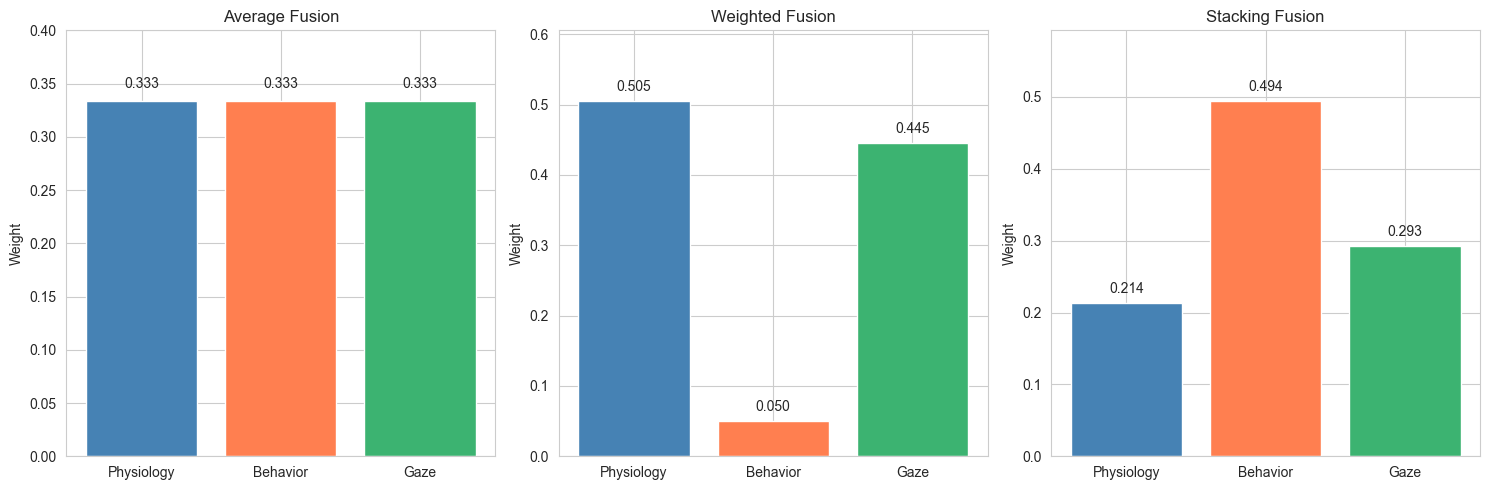

In [15]:
weights_df = pd.DataFrame({
    'Modality': modality_names,
    'Average': results_avg['weights'],
    'Weighted': results_weighted['weights'],
    'Stacking': results_stacking['weights']
})

print("\n" + "="*50)
print("MODALITY WEIGHTS (Influence on Prediction)")
print("="*50)
print(weights_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['steelblue', 'coral', 'mediumseagreen']

for idx, method in enumerate(['Average', 'Weighted', 'Stacking']):
    ax = axes[idx]
    weights = weights_df[method].values
    bars = ax.bar(modality_names, weights, color=colors)
    ax.set_ylabel('Weight')
    ax.set_title(f'{method} Fusion')
    ax.set_ylim([0, max(weights) * 1.2])
    for i, v in enumerate(weights):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Save Results to CSV

Exporting all results for later analysis without re-running.

In [ ]:
import os
os.makedirs('../../data/results/fusion_model_results_POST', exist_ok=True)

# 1. Save method comparison results
if 'comparison_df' in locals():
    output_file = '../../data/results/fusion_model_results_POST/late_fusion_model_POST_method_comparison.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"✓ Saved method comparison to: {output_file}")

# 2. Save modality weights for each fusion method
if 'weights_df' in locals():
    output_file = '../../data/results/fusion_model_results_POST/late_fusion_model_POST_modality_weights.csv'
    weights_df.to_csv(output_file, index=False)
    print(f"✓ Saved modality weights to: {output_file}")

# 3. Save weighted fusion results (best method)
if 'results_weighted' in locals():
    weighted_summary = pd.DataFrame({
        'Metric': ['Accuracy', 'Accuracy_SEM', 'F1_Score', 'F1_SEM', 'N_Subjects', 'N_Trials'],
        'Value': [
            results_weighted.get('accuracy', results_weighted.get('accuracy_mean', 0)),
            results_weighted.get('accuracy_sem', 0),
            results_weighted.get('f1_score', results_weighted.get('f1_mean', 0)),
            results_weighted.get('f1_sem', 0),
            results_weighted.get('n_subjects', len(np.unique(subjects))),
            results_weighted.get('n_trials', len(y))
        ]
    })
    output_file = '../../data/results/fusion_model_results_POST/late_fusion_model_POST_weighted_fusion_summary.csv'
    weighted_summary.to_csv(output_file, index=False)
    print(f"✓ Saved weighted fusion summary to: {output_file}")

# 4. Save subject-level accuracies
if 'result_df' in locals():
    # This is the subject accuracy with sessions
    output_file = '../../data/results/fusion_model_results_POST/late_fusion_model_POST_subject_accuracies.csv'
    result_df.to_csv(output_file, index=False)
    print(f"✓ Saved subject accuracies to: {output_file}")
elif 'results_weighted' in locals() and 'subject_accs' in results_weighted:
    # Create from weighted results
    subject_df = pd.DataFrame({
        'subject_id': list(results_weighted['subject_accs'].keys()),
        'accuracy': list(results_weighted['subject_accs'].values()),
        'f1_score': list(results_weighted['subject_f1s'].values()) if 'subject_f1s' in results_weighted else None,
        'num_trials': list(results_weighted['subject_num_trials'].values()) if 'subject_num_trials' in results_weighted else None
    })
    output_file = '../../data/results/fusion_model_results_POST/late_fusion_model_POST_subject_accuracies.csv'
    subject_df.to_csv(output_file, index=False)
    print(f"✓ Saved subject accuracies to: {output_file}")

print(f"\nAll results saved to: ../../data/results/fusion_model_results_POST/")
